In [39]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim import lr_scheduler

import os
import copy

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 数据集介绍

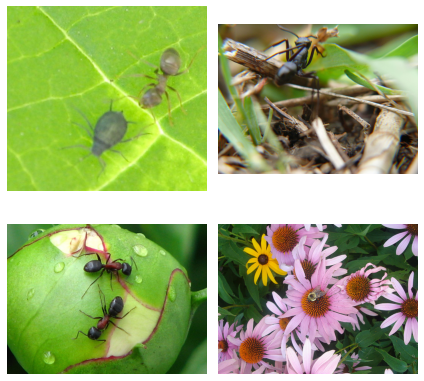

In [6]:
# 显示一下具体的图像
dirPath = '/content/drive/My Drive/Machine Learning/dataset/hymenoptera_data_Unzipped/'
imageList = [dirPath+'hymenoptera_data/train/ants/178538489_bec7649292.jpg', dirPath+'hymenoptera_data/train/ants/424873399_47658a91fb.jpg',
            dirPath+'hymenoptera_data/train/ants/533848102_70a85ad6dd.jpg', dirPath+'hymenoptera_data/train/bees/196658222_3fffd79c67.jpg']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,6))

for i, img_path in enumerate(imageList):
    img_check1 = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_check1 = cv2.cvtColor(img_check1, cv2.COLOR_BGR2RGB) # BGR => RGB
    # 图片进行显示
    axes[i//2, i%2].axis("off")
    axes[i//2, i%2].imshow(img_check1)
    
fig.tight_layout()

## 数据预处理

在数据预处理的时候, 我们会对原始图片进行旋转等操作, 这样增加数据的多样性(这里并没有增加数据的数量, 只是增加了多样性)

In [8]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        # 加入旋转等数据增强技术，加大模型训练的难度，提高模型的稳健性
        transforms.RandomResizedCrop(224), # 随机剪裁
        transforms.RandomHorizontalFlip(), # 随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    # 测试集输入时，无需加入旋转等操作
    'val': transforms.Compose([
        # resize 操作的目的是将任意大小的图片转为模型规定的输入大小
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

## 数据封装

In [34]:
dirPath = '/content/drive/My Drive/Machine Learning/dataset/hymenoptera_data_Unzipped/hymenoptera_data'
# 将数据集封装到 PyTorch 中数据加载器中
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(dirPath, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=True, num_workers=0) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# 看一下训练集和测试集里面两类的数量
print('Train: ', image_datasets['train'].targets.count(0), image_datasets['train'].targets.count(1))
print('Test:', image_datasets['val'].targets.count(0), image_datasets['val'].targets.count(1))

Train:  123 121
Test: 70 83


## 模型的建立


In [47]:
model = torchvision.models.resnet18(pretrained=True).to(device)

In [48]:
# 查看模型的最后一层
model.fc

Linear(in_features=512, out_features=1000, bias=True)

原始的resnet18输出是1000, 但是我们的模型输出是2, 所以我们要修改模型的输出

In [49]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 重新定义 fc：输入节点数不变的情况下，将输出节点改为 2
model = model.to(device)
model.fc

Linear(in_features=512, out_features=2, bias=True)

## 定义损失函数和优化器

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

## 模型的训练与测试

这一次训练的时候, 我们会保存模型最优的一次检测结果, 和他对应的网络的参数.

In [52]:
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

num_epochs = 10
n_total_steps = len(dataloaders['train'])

LossList = [] # 记录每一个epoch的loss
AccuryList = [] # 每一个epoch的accury

for epoch in range(num_epochs):
    # -------
    # 开始训练
    # -------
    model.train() # 切换为训练模型
    totalLoss = 0
    for i, (images, labels) in enumerate(dataloaders['train']):
        images = images.to(device) # 图片大小转换
        labels = labels.to(device)

        # 正向传播以及损失的求取
        outputs = model(images)
        loss = criterion(outputs, labels)
        totalLoss = totalLoss + loss.item()

        # 反向传播
        optimizer.zero_grad() # 梯度清空
        loss.backward() # 反向传播
        optimizer.step() # 权重更新
        step_lr_scheduler.step()

        if (i+1) % 3 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, LR: {:.4f}'.format(epoch+1, num_epochs, i+1, n_total_steps, totalLoss/(i+1), optimizer.param_groups[0]['lr']))
    
    LossList.append(totalLoss/(i+1))

    # ---------
    # 开始测试
    # ---------
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataloaders['val']:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1) # 预测的结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100.0 * correct / total # 在测试集上总的准确率
        AccuryList.append(acc)

        if acc > best_acc:
            best_acc = acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print('更新模型参数, {}'.format(epoch))
        print('Accuracy of the network on the {} test images: {} %'.format(total, acc))

print("模型训练完成")

Epoch [1/10], Step [3/13], Loss: 0.6536, LR: 0.0010
Epoch [1/10], Step [6/13], Loss: 0.6469, LR: 0.0010
Epoch [1/10], Step [9/13], Loss: 0.6254, LR: 0.0010
Epoch [1/10], Step [12/13], Loss: 0.6002, LR: 0.0008
更新模型参数, 0
Accuracy of the network on the 153 test images: 86.9281045751634 %
Epoch [2/10], Step [3/13], Loss: 0.4686, LR: 0.0008
Epoch [2/10], Step [6/13], Loss: 0.4018, LR: 0.0008
Epoch [2/10], Step [9/13], Loss: 0.3760, LR: 0.0006
Epoch [2/10], Step [12/13], Loss: 0.3644, LR: 0.0006
更新模型参数, 1
Accuracy of the network on the 153 test images: 89.54248366013071 %
Epoch [3/10], Step [3/13], Loss: 0.3621, LR: 0.0006
Epoch [3/10], Step [6/13], Loss: 0.2974, LR: 0.0005
Epoch [3/10], Step [9/13], Loss: 0.2662, LR: 0.0005
Epoch [3/10], Step [12/13], Loss: 0.2790, LR: 0.0005
更新模型参数, 2
Accuracy of the network on the 153 test images: 90.84967320261438 %
Epoch [4/10], Step [3/13], Loss: 0.2359, LR: 0.0004
Epoch [4/10], Step [6/13], Loss: 0.2800, LR: 0.0004
Epoch [4/10], Step [9/13], Loss: 0.2

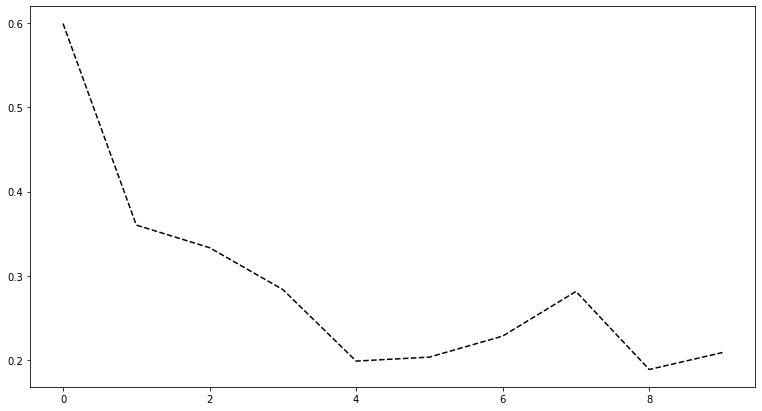

In [53]:
# 绘制loss的变化
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
axes.plot(LossList, 'k--')

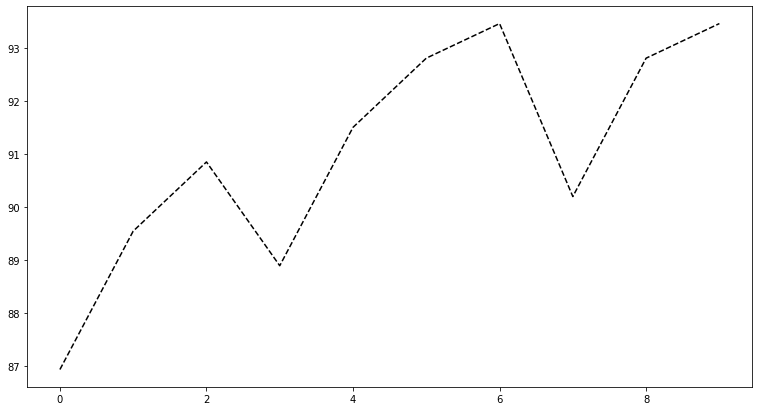

In [54]:
# 绘制loss的变化
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
axes.plot(AccuryList, 'k--')